# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd   # for importing dataset.
import shutil         # for saving the files.
import numpy as np    # for feature 1
import spacy          # for feature 3
from textblob import TextBlob # for feature 12
import nltk           # for feature 16
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 
!pip install pyspellchecker # for feature 19
from spellchecker import SpellChecker  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Dataset


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Project/dataset.csv")
liwc_dictionary = pd.read_csv("/content/drive/MyDrive/Project/LIWC_dictionary.csv")
print(dataset.head(5))
print("\n----\n")
print(liwc_dictionary.head(5))

        date             reviewer_id              product_id label  \
0   6/8/2011  IFTr6_6NI4CgCVavIL9k5g  tQfLGoolUMu2J0igcWcoZg     N   
1  8/30/2011  c_-hF15XgNhlyy_TqzmdaA  tQfLGoolUMu2J0igcWcoZg     N   
2  6/26/2009  CiwZ6S5ZizAFL5gypf8tLA  tQfLGoolUMu2J0igcWcoZg     N   
3  9/16/2010  nf3q2h-kSQoZK2jBY92FOg  tQfLGoolUMu2J0igcWcoZg     N   
4   2/5/2010  Sb3DJGdZ4Rq__CqxPbae-g  tQfLGoolUMu2J0igcWcoZg     N   

   star_rating                                        review_text  
0            5  Let me begin by saying that there are two kind...  
1            3  The only place inside the Loop that you can st...  
2            5  I have walked by the Tokyo Hotel countless tim...  
3            1  If you are considering staying here, watch thi...  
4            3  This place is disgusting, absolutely horrible,...  

----

  perceptual_processes        time     space personal_pronoun  \
0                acid*     abrupt*     above              hed   
1               acrid*       after

# Descriptive Statistics of dataset

In [ ]:
fake_review_count = 0
real_review_count = 0
fake_review_word_count_sum = 0
real_review_word_count_sum = 0
real_reviewers = {}
fake_reviewers = {}
fake_review_extreme_rating_count = 0
real_review_extreme_rating_count = 0

for i in range(len(dataset)):

  if dataset.loc[i,"label"] == 'Y': # fake review

    fake_review_count += 1 

    fake_review_word_count_sum += len(str(dataset.loc[i,"review_text"]).split())

    if dataset.loc[i,'reviewer_id'] not in fake_reviewers:
      fake_reviewers[dataset.loc[i,'reviewer_id']] = 1
    else:
      fake_reviewers[dataset.loc[i,'reviewer_id']] += 1
    
    if dataset.loc[i,'star_rating'] in {1,5}:
      fake_review_extreme_rating_count += 1


  else: # real review

    real_review_count += 1 

    real_review_word_count_sum += len(str(dataset.loc[i,"review_text"]).split())

    if dataset.loc[i,'reviewer_id'] not in real_reviewers:
      real_reviewers[dataset.loc[i,'reviewer_id']] = 1
    else:
      real_reviewers[dataset.loc[i,'reviewer_id']] += 1
    
    if dataset.loc[i,'star_rating'] in {1,5}:
      real_review_extreme_rating_count += 1

print(f"Total Number of Reviews: {fake_review_count + real_review_count}")
print(f"Number of Real Reviews: {real_review_count}")
print(f"Number of Fake Reviews: {fake_review_count}")
print(f"Percentage of fake reviews: {'{:.2f}'.format(fake_review_count / (fake_review_count + real_review_count) * 100)}%")

print(f"\nTotal Number of Reviewers: {len(fake_reviewers) + len(real_reviewers)}")
print(f"Percentage of spam reviewers: {'{:.2f}'.format(len(fake_reviewers) / (len(fake_reviewers) + len(real_reviewers)) * 100)}%")

print(f"\nMean length of a fake review: {'{:.3f}'.format(fake_review_word_count_sum / fake_review_count)}")
print(f"Mean length of a real review: {'{:.3f}'.format(real_review_word_count_sum / real_review_count)}")

print(f"\nMean number of reviews posted by fake reviewer: {'{:.3f}'.format(fake_review_count / len(fake_reviewers))}")
print(f"Mean number of reviews posted by fake reviewer: {'{:.3f}'.format(real_review_count / len(real_reviewers))}")

print(f"\nPercentage of extreme ratings (1 or 5) in fake reviews: {'{:.2f}'.format(fake_review_extreme_rating_count / fake_review_count * 100)}%")
print(f"Percentage of extreme ratings (1 or 5) in real reviews: {'{:.2f}'.format(real_review_extreme_rating_count / real_review_count * 100)}%")

Total Number of Reviews: 67395
Number of Real Reviews: 58476
Number of Fake Reviews: 8919
Percentage of fake reviews: 13.23%

Total Number of Reviewers: 38198
Percentage of spam reviewers: 20.26%

Mean length of a fake review: 102.406
Mean length of a real review: 144.456

Mean number of reviews posted by fake reviewer: 1.152
Mean number of reviews posted by fake reviewer: 1.920

Percentage of extreme ratings (1 or 5) in fake reviews: 56.67%
Percentage of extreme ratings (1 or 5) in real reviews: 40.77%


# Preprocessing: Changing Labels


In [ ]:
# Changing the labels from Y-N to 1-0.
fake_review_count = 0
real_review_count = 0

print("Progress...")
for i in range(len(dataset)):
  if dataset.loc[i,"label"] == 'N':   # real review
    dataset.loc[i,"label"] = 0     
    real_review_count += 1
  else:   
    dataset.loc[i,"label"] = 1
    fake_review_count += 1
  
  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")

print(f"Fake review Count = {fake_review_count}")
print(f"Real review Count = {real_review_count}")
print(f"Total review Count = {real_review_count + fake_review_count}")
print("\n\n")

print(dataset.head(5))

# Preprocessing: Lower Case

In [ ]:
# LIWC requires the words to be in lowercase.
dataset["lower_case_review_text"] = dataset["review_text"].str.lower()
print(dataset.head(5))

# Preprocessing: Punctuation Removal

In [ ]:
# The only allowed puntucation for LIWC is \'
punctuations = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'  
dataset["lower_case_review_text"] = dataset[
    "lower_case_review_text"].str.replace("[{}]".format(punctuations), "", regex = True)
print(dataset.head(5))

# Preprocessing: Cardinality & Word Count

In [ ]:
# The mathematical representation given in paper are all set operations.
# Word count is the most used attribute, hence having it cached.

print("Progress...")
for i in range(len(dataset)): 
  words = set(str(dataset.loc[i,"lower_case_review_text"]).split())
  dataset.loc[i,"lower_case_review_text"] = ' '.join(words) # cardinality 
  dataset.loc[i,"review_text_word_count"] = len(words)      # word count

  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")

print(dataset.head(5))

# Saving Processed dataset

In [ ]:
dataset.to_csv("processed_dataset.csv", index = False, encoding = "utf-8")
shutil.copy("processed_dataset.csv", "/content/drive/MyDrive/Project")

# Loading Files

In [ ]:
processed_dataset = pd.read_csv("/content/drive/MyDrive/Project/processed_dataset.csv")
features_extraction = pd.read_csv("/content/drive/MyDrive/Project/features.csv")
# "feature_extraction" file will have 67395 rows with all entries 0. 
# Due to the fact that creating a cell take longer than updating it.

print(processed_dataset.head(5))
print("\n----\n")
print(features_extraction.head(5))

# LIWC function

In [ ]:
def get_LIWC_dictionary_words(categories):
  """
  Input:-   Categories - a list of categories, whose words are needed.
  Output:-  actual - a set of exact words
            regex - a list of regular expressions without trailing '*'
  Algorithm:- 

  actual = set()
  regex = []

  For each row in LIWC_Dictionary
    For each category in LIWC_Dictionary
      word = LIWC_Dictionary[row][category] 
      if word is regular expression:
        regex.append(word)
      else
        actual.add(word)
  
  return actual, regex
  """
  liwc_dictionary = pd.read_csv("/content/drive/MyDrive/Project/LIWC_dictionary.csv")

  actual = set()
  regex = []

  for i in range(len(liwc_dictionary)):
    for category in categories:
      word = str(liwc_dictionary.loc[i, category])  #str() for detecting "nan"
      if word != "nan":
        if word[-1] == "*":
          regex.append(word[:-1])
        else:
          actual.add(word)
          
  return actual, regex

# Feature 1: Generalization Terms Usage

In [ ]:
# List of nineteen absolutist words provided by M. Al-Mosaiwi et al.[196]
# storing the words in a set, which offers O(1) access time.

generalization_terms = {'absolutely', 'all', 'always', 'complete', 
                        'completely', 'constant',  'constantly', 'definitely', 
                        'entire', 'ever', 'every', 'everyone', 'everything', 
                        'full', 'must', 'never', 'nothing', 'totally', 'whole'}

print("Progress...")
for i in range(len(processed_dataset)):
  count = 0
  words = str(processed_dataset.loc[i,"lower_case_review_text"]).split()
  for word in words: 
    if word in generalization_terms:
      count += 1
    
  if processed_dataset.loc[i,"review_text_word_count"] == 0:
    features_extraction.loc[i,'f01_generalization_terms_usage'] = 0
  else:
    features_extraction.loc[i,'f01_generalization_terms_usage'] = count / processed_dataset.loc[i,'review_text_word_count']

  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")
print("\n\n")
print(features_extraction.head(5))

# Feature 2: Richness of detials

In [ ]:
categories = ["time", "space", "perceptual_processes"]
actual, regex = get_LIWC_dictionary_words(categories)

print("Progress...")
for i in range(len(processed_dataset)):
  count = 0
  words = str(processed_dataset.loc[i,"lower_case_review_text"]).split()
  for word in words: 
    if word in actual:
      count += 1
    else:
      for re in regex:
        if word[:len(re)] == re:
          count += 1
          break

  if processed_dataset.loc[i,"review_text_word_count"] == 0:
    features_extraction.loc[i,'f02_richness_of_details'] = 0
  else:
    features_extraction.loc[i,'f02_richness_of_details'] = count / processed_dataset.loc[i,'review_text_word_count']

  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")
print("\n\n")
print(features_extraction.head(5))

# Feature 3: Richness of verifiable details

In [ ]:
NER = spacy.load("en_core_web_sm") 

categories = ["time", "space", "perceptual_processes"]
actual, regex = get_LIWC_dictionary_words(categories)

print("Progress...")
for i in range(len(processed_dataset)):

  unverifiable_count = 0
  words = str(processed_dataset.loc[i,"lower_case_review_text"]).split()
  for word in words: 
    if word in actual:
      unverifiable_count += 1
    else:
      for re in regex:
        if word[:len(re)] == re:
          unverifiable_count += 1
          break

  verifiable_count = 0  
  text = NER(processed_dataset.loc[i,"review_text"])

  verifiable_count = len(text.ents)

  if verifiable_count != 0 and unverifiable_count != 0:
    result = verifiable_count / (unverifiable_count + verifiable_count)
  elif unverifiable_count == 0 and verifiable_count != 0:
    result = 1
  else:
    result = 0

  features_extraction.loc[i,"f03_richness_of_verifiable_details"] = result

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print(features_extraction.head(5))

# Feature 4: Length of the review

In [ ]:
features_extraction["f04_length_of_the_review"] = processed_dataset['review_text_word_count']
print(features_extraction.head(5))

# Feature 5,6,7: Pronouns Usage

In [ ]:
categories = ["personal_pronoun"]
PP_actual, PP_regex = get_LIWC_dictionary_words(categories)

categories = ["first_person_singular"]
FS_actual, FS_regex = get_LIWC_dictionary_words(categories)

categories = ["first_person_plural"]
FP_actual, FP_regex = get_LIWC_dictionary_words(categories)

categories = ["third_person_singular", "third_person_plural"]
TP_actual, TP_regex = get_LIWC_dictionary_words(categories)

print("Progress...")
for i in range(len(processed_dataset)):
  PP_count = 0
  FS_count = 0
  FP_count = 0
  TP_count = 0

  words = str(processed_dataset.loc[i,"lower_case_review_text"]).split()
  for word in words: 

    if word in PP_actual:
      PP_count += 1
    else:
      for re in PP_regex:
        if word[:len(re)] == re:
          PP_count += 1
          break

    if word in FS_actual:
      FS_count += 1
    else:
      for re in FS_regex:
        if word[:len(re)] == re:
          FS_count += 1
          break

    if word in FP_actual:
      FP_count += 1
    else:
      for re in FP_regex:
        if word[:len(re)] == re:
          FP_count += 1
          break
    
    if word in TP_actual:
      TP_count += 1
    else:
      for re in TP_regex:
        if word[:len(re)] == re:
          TP_count += 1
          break

  if PP_count == 0: # since PP is the denominator
    features_extraction.loc[i,"f05_first_person_singular_pronouns_usage"] = 0
    features_extraction.loc[i,"f06_first_person_plural_pronouns_usage"] = 0
    features_extraction.loc[i,"f07_third_person_pronouns_usage"] = 0
    continue
  
  if FS_count == 0:
    features_extraction.loc[i,"f05_first_person_singular_pronouns_usage"] = 0
  else:
    features_extraction.loc[i,"f05_first_person_singular_pronouns_usage"] = FS_count / PP_count
      
  if FP_count == 0:
    features_extraction.loc[i,"f06_first_person_plural_pronouns_usage"] = 0
  else:
    features_extraction.loc[i,"f06_first_person_plural_pronouns_usage"] = FP_count / PP_count

  if TP_count == 0:
    features_extraction.loc[i,"f07_third_person_pronouns_usage"] = 0
  else:
    features_extraction.loc[i,"f07_third_person_pronouns_usage"] = TP_count / PP_count

  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")
print("\n\n")
print(features_extraction.head(5))

# Feature 8,9: Verbs Usage

In [ ]:
nlp = spacy.load("en_core_web_sm") # spacy model for detecting English words

print("Progress...")
for i in range(len(processed_dataset)):

  verbs_count = 0
  present_verbs_count = 0
  past_verbs_count = 0

  text = processed_dataset.loc[i,"review_text"]
  
  doc = nlp(text)

  for token in doc:
    if token.pos_ == "VERB":
      verbs_count += 1
      if token.tag_ == "VBZ" or token.tag_ == "VBP" or token.tag_ =="VBG":
        present_verbs_count += 1
      elif token.tag_ == "VBD":
        past_verbs_count += 1

  if verbs_count != 0:
    features_extraction.loc[i,"f08_present_tense_verbs_usage"] = present_verbs_count / verbs_count
    features_extraction.loc[i,"f09_past_tense_verbs_usage"] = past_verbs_count / verbs_count
  else:
    features_extraction.loc[i,"f08_present_tense_verbs_usage"] = 0
    features_extraction.loc[i,"f09_past_tense_verbs_usage"] = 0
  
  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print(features_extraction.head(5))

# Feature 10: Passive Voice

In [ ]:
nlp = spacy.load("en_core_web_sm")

def is_passive(sentence):
    doc = nlp(sentence)
    for token in doc:
        if token.dep_ == "nsubjpass" or token.dep_ == "auxpass" or token.dep_ == "csubjpass":       
            return True
    return False

print("Progress...")
for i in range(len(processed_dataset)):
  text = processed_dataset.loc[i,"review_text"]
  doc = nlp(text)

  sentence_count = 0
  passive_voice_count = 0

  for sentence in doc.sents:
      if is_passive(str(sentence)):
          passive_voice_count += 1
      sentence_count += 1
  features_extraction.loc[i,"f10_passive_voice_usage"] = passive_voice_count / sentence_count
  
  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print(features_extraction.head(5))

# Feature 11: Negations Usage

In [ ]:
categories = ["negations"]
actual, regex = get_LIWC_dictionary_words(categories)

print("Progress...")
for i in range(len(processed_dataset)):
  count = 0
  words = str(processed_dataset.loc[i,"lower_case_review_text"]).split()
  for word in words: 
    if word in actual:
      count += 1
    else:
      for re in regex:
        if word[:len(re)] == re:
          count += 1
          break

  if processed_dataset.loc[i,"review_text_word_count"] == 0:
    features_extraction.loc[i,'f11_negations_usage'] = 0
  else:
    features_extraction.loc[i,'f11_negations_usage'] = count / processed_dataset.loc[i,'review_text_word_count']
  
  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")
print("\n\n")
print(features_extraction.head(5))

# Feature 12: Sentiment Polarity

In [ ]:
features_extraction["f12_sentiment_polarity"] = processed_dataset["review_text"].apply(lambda row: TextBlob(row).sentiment.polarity)
print(features_extraction.head(5))

# Feature 13: Sentiment Subjectivity

In [ ]:
features_extraction["f13_sentiment_subjectivity"] = processed_dataset["review_text"].apply(lambda row: TextBlob(row).sentiment.subjectivity)
print(features_extraction.head(5))

# Feature 14,15: Emotion Words Usage

In [ ]:
categories = ["affective_processes"]
AF_actual, AF_regex = get_LIWC_dictionary_words(categories)

categories = ["positive_emotions"]
PE_actual, PE_regex = get_LIWC_dictionary_words(categories)

categories = ["negative_emotions"]
NE_actual, NE_regex = get_LIWC_dictionary_words(categories)

print("Progress...")
for i in range(len(processed_dataset)):
  AF_count = 0
  PE_count = 0
  NE_count = 0

  words = str(processed_dataset.loc[i,"lower_case_review_text"]).split()
  for word in words: 

    if word in AF_actual:
      AF_count += 1
    else:
      for re in AF_regex:
        if word[:len(re)] == re:
          AF_count += 1
          break

    if word in PE_actual:
      PE_count += 1
    else:
      for re in PE_regex:
        if word[:len(re)] == re:
          PE_count += 1
          break

    if word in NE_actual:
      NE_count += 1
    else:
      for re in NE_regex:
        if word[:len(re)] == re:
          NE_count += 1
          break
  
  if AF_count == 0:
    features_extraction.loc[i,"f14_positive_emotion_words_usage"] = 0
    features_extraction.loc[i,"f15_negative_emotion_words_usage"] = 0
    continue

  if PE_count == 0:
    features_extraction.loc[i,"f14_positive_emotion_words_usage"] = 0
  else:
    features_extraction.loc[i,"f14_positive_emotion_words_usage"] = PE_count / AF_count

  if NE_count == 0:
    features_extraction.loc[i,"f15_negative_emotion_words_usage"] = 0
  else:
    features_extraction.loc[i,"f15_negative_emotion_words_usage"] = NE_count / AF_count

  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")
print("\n\n")
print(features_extraction.head(5))

# Feature 16: Location of maximum affect

In [ ]:
"""
Algorithm

(a) tokenize each text at the sentence level,
(b) score each sentence using the LIWC category ‘‘affective processes’’ to calculate the emotion ratio, 
(c) determine the sentence number with the maximum score of affect, and
(d) divide the sentence number by the number of sentences in the text.
  
for review in joined_date:
  sentences = sent_tokenize(review)

  max_index = 0
  max_count = 0 

  for i,sentence in sentences:
    count = 0
    words = sentence.split()
    for word in words:
      if word in affective processes
        count += 1

    if count >= max_count
      max_index = i
      max_count = count
  
  f["f16_location_of_maximum_affect"] = max_index / len(sentences)
"""

actual, regex = get_LIWC_dictionary_words(["affective_processes"])

print("Progress...")
for i in range(len(processed_dataset)): 

  sentences = sent_tokenize(str(processed_dataset.loc[i,"review_text"]))

  max_ratio_index = 0
  max_ratio = 0 

  j = 0
  for sentence in sentences:        

    count = 0 # to count number of affective words

    words = word_tokenize(sentence) # word tokenisation
    for word in words:
      if word in actual:
        count += 1
      else:
        for reg in regex:
          if word[:len(reg)] == reg:
            count += 1
            break

    ratio = count / len(words)

    if ratio >= max_ratio:
      max_ratio_index = j
      max_ratio = ratio

    j += 1

  features_extraction.loc[i,"f16_location_of_maximum_affect"] = (max_ratio_index / len(sentences)) if len(sentences) != 0 else 0
  
  if i % 5000 == 0 and i != 0 :
    print(f"{i}\trows done")
print("----------------------")

print(features_extraction.head(5))

# Feature 17,18: Uncertainty Features

In [ ]:
categories = ["certainty"]
CR_actual, CR_regex = get_LIWC_dictionary_words(categories)

categories = ["tentative"]
UC_actual, UC_regex = get_LIWC_dictionary_words(categories)

print("Progress...")
for i in range(len(processed_dataset)):
  CR_count = 0
  UC_count = 0

  words = str(processed_dataset.loc[i,"lower_case_review_text"]).split()
  for word in words: 

    if word in CR_actual:
      CR_count += 1
    else:
      for re in CR_regex:
        if word[:len(re)] == re:
          CR_count += 1
          break

    if word in UC_actual:
      UC_count += 1
    else:
      for re in UC_regex:
        if word[:len(re)] == re:
          UC_count += 1
          break

  word_count = processed_dataset.loc[i,"review_text_word_count"]
  if word_count == 0:
    features_extraction.loc[i,"f17_certainty_words_usage"] = 0
    features_extraction.loc[i,"f18_uncertainty_words_usage"] = 0
    continue

  if CR_count == 0:
    features_extraction.loc[i,"f17_certainty_words_usage"] = 0
  else:
    features_extraction.loc[i,"f17_certainty_words_usage"] = CR_count / word_count

  if UC_count == 0:
    features_extraction.loc[i,"f18_uncertainty_words_usage"] = 0
  else:
    features_extraction.loc[i,"f18_uncertainty_words_usage"] = UC_count / word_count

  if i % 5000 == 0 and i != 0:
    print(f"{i}\t rows complete")
print("----------------------")
print("\n\n")
print(features_extraction.head(5))

# Feature 19: Misspelled Words Ratio

In [ ]:
spell = SpellChecker()
features_extraction["f19_misspelled_words_ratio"] = processed_dataset["lower_case_review_text"].apply(lambda row: len(spell.unknown(str(row).split())))
features_extraction["f19_misspelled_words_ratio"] = features_extraction["f19_misspelled_words_ratio"].div(processed_dataset["review_text_word_count"])
print(features_extraction.head(5))

# Feature 20: Rating-Sentiment Inconsistency

In [ ]:
MIN_POLARITY = -1
MAX_POLARITY = 1
MIN_STAR = 1
MAX_STAR = 5

print("Progress...")
for i in range(len(processed_dataset)):    
  features_extraction.loc[i,"f20_rating_sentiment_inconsistency"] = (features_extraction.loc[i,"f12_sentiment_polarity"] - MIN_POLARITY)/(MAX_POLARITY - MIN_POLARITY) - (processed_dataset.loc[i,"star_rating"] - MIN_STAR)/(MAX_STAR - MIN_STAR)

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")
    
print(features_extraction.head(5))

# Feature 21: Number of Reviews

In [ ]:
"""
Algorithm
The task is done in two passes of the dataset using a dictionary.

Create a dictionary to hold (user_id, count_of_review_posts) as key-value pairs.

First pass:- 
For each review increment the reviewer"s count.

Second pass:-
For each review assign the corresponding value of reviewer from dictionary. 

"""

reviews_count_per_user = {}

print("Pass 1 Status:- ")
for i in range(len(processed_dataset)):   

  if processed_dataset.loc[i,"reviewer_id"] in reviews_count_per_user:
    reviews_count_per_user[processed_dataset.loc[i,"reviewer_id"]] += 1
  else:
    reviews_count_per_user[processed_dataset.loc[i,"reviewer_id"]] = 1

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")


print("\n\nPass 2 Status:- ")
for i in range(len(processed_dataset)):

  features_extraction.loc[i,"f21_number_of_reviews"] = reviews_count_per_user[processed_dataset.loc[i,"reviewer_id"]]

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print(features_extraction.head(5))

# Feature 22: Rating Deviation

In [ ]:
"""
Algorithm
The task is done in two passes of the dataset using a dictionary of lists.

Create a dictionary to hold (product_id, list of ratings) as key-value pairs.

First pass:- 
For each product add the rating to the list(value of dictionary).

Second pass:-
For each review, find the corresponding avg of product_id and hence the req val. 

"""
MIN_STAR = 1
MAX_STAR = 5

product_ratings_list={} 

print("Pass 1 Status:-")
for i in range(len(processed_dataset)):
  if processed_dataset.loc[i,"product_id"] in product_ratings_list:
    product_ratings_list[processed_dataset.loc[i,"product_id"]] += [processed_dataset.loc[i, "star_rating"]]
  else:
    product_ratings_list[processed_dataset.loc[i,"product_id"]] = [processed_dataset.loc[i,"star_rating"]]

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print("\n\nPass 2 Status:-")
for i in range(len(processed_dataset)):   

  average_product_rating = sum(product_ratings_list[processed_dataset.loc[i,"product_id"]]) / len(product_ratings_list[processed_dataset.loc[i,"product_id"]])
  features_extraction.loc[i,"f22_rating_deviation"] = (processed_dataset.loc[i,"star_rating"] - average_product_rating ) / (MAX_STAR - MIN_STAR)

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print(features_extraction.head(5))

# Feature 23: Extreme Rating Ratio

In [ ]:
"""
Algorithm
The task is done in two passes of the rows and using dictionary.

Create a dictionary to hold (user_id, count_of_max_rating_reviews) as key-value pairs.

First pass:- 
For each review 
  increment the reviewer's count if the rating is in {1,5}

Second pass:-
For each review assign the corresponding value of reviewer from dictionary. 

"""
MAX_RATING = 5
MIN_RATING = 1
extreme_rating_count_per_user = {}

print("Pass 1 Status:- ")
for i in range(len(processed_dataset)):                  
  if processed_dataset.loc[i,"star_rating"] == MIN_RATING or processed_dataset.loc[i,"star_rating"] == MAX_RATING:
    if processed_dataset.loc[i,"reviewer_id"] in extreme_rating_count_per_user:
      extreme_rating_count_per_user[processed_dataset.loc[i,"reviewer_id"]] += 1
    else:
      extreme_rating_count_per_user[processed_dataset.loc[i,"reviewer_id"]] = 1

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print("Pass 2 Status:- ")
for i in range(len(processed_dataset)):
  features_extraction.loc[i,"f23_extreme_rating_ratio"] = (extreme_rating_count_per_user[processed_dataset.loc[i,"reviewer_id"]] / features_extraction.loc[i,"f21_number_of_reviews"]) if processed_dataset.loc[i,"reviewer_id"] in extreme_rating_count_per_user else 0.0
  
  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")
    
print(features_extraction.head(5))

# Feature 24: Maximum Reviewing Frequency

In [ ]:
"""
Algorithm 
The complexity of the algorithm is O(n)
The data structure used here is dictionary of dictionaries.

There are three passes. 

Pass1:- Passing over data. 
Here we will be just storing the user_id and 
  the number of different dates on which the user has texted.
The former is the outer dictionary and latter is the inner dictionary. 

The outer dictionary's key is user_id and value is inner dictionary. 
The inner dictionary's key is date and value is the count of reviews on that date. 

Effectively giving out the following code:
dic = {user_id, nested_dic = {date, count}}
eg:- {923: {"2014-12-08": 1}, 924: {"2013-05-16": 1}, 925: {"2013-07-01": 1}, 926: {"2011-07-28": 1}, 927: {"2010-11-01": 1}}
What it contains is, the list of days a user has written review and along with the number of reviews on that day. 

------

Pass2:- Passing over the dic
Here will be using another dictionary to store the maximum reviews on a date. 
The above is extracted by iterating through the dictionary. 
dic2 = { user_id, max_count }
eg:- {923: 1, 924: 1, 925: 1, 926: 1, 927: 1}

------

Pass3:- Filling in the features table.

------

Pseudo Code:- 

#first pass
for i in range(data):
  if user_id exists in dic:
    if date exists in dic[user_id]
      dic[user_id][date] += 1
    else:
      #implies date doesn"t exists
      dic[user_id][date] = 1
  else
    #implies user doesn"t exists
    dic[user_id] = {} 

#second pass
dic2 = { user_id, max_count }

for user_id in dic: #iterating through every key of dic
  count = 0
  
  for date in dic[user_id]: 
    count = max(count, dic[user_id][date])

  dic2[user_id] = count

#Third pass
for i in range(data):
  data[f24_maximum_reviewing_frequency] = dic2[data.loc[i,"user_id"]]
"""

user_review_dates_dictionary = {}

print("Pass 1 Status:- ")
for i in range(len(processed_dataset)):
  if processed_dataset.loc[i,"reviewer_id"] in user_review_dates_dictionary:
    
    if processed_dataset.loc[i,"date"] in user_review_dates_dictionary[processed_dataset.loc[i,"reviewer_id"]]:
      user_review_dates_dictionary[processed_dataset.loc[i,"reviewer_id"]][processed_dataset.loc[i,"date"]] += 1
    else:
      user_review_dates_dictionary[processed_dataset.loc[i,"reviewer_id"]][processed_dataset.loc[i,"date"]] = 1

  else:
    user_review_dates_dictionary[processed_dataset.loc[i,"reviewer_id"]] = {}
    user_review_dates_dictionary[processed_dataset.loc[i,"reviewer_id"]][processed_dataset.loc[i,"date"]] = 1
  
  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")


user_max_review_per_day_dictionary = {} 

for user_id in user_review_dates_dictionary:
  count = 0

  for date in user_review_dates_dictionary[user_id]:
    count = max(count, user_review_dates_dictionary[user_id][date])
  
  user_max_review_per_day_dictionary[user_id] = count

print("Pass 2 Status:- ")
for i in range(len(processed_dataset)):
  features_extraction.loc[i,"f24_maximum_reviewing_frequency"] = user_max_review_per_day_dictionary[processed_dataset.loc[i,"reviewer_id"]]

  if i % 5000 == 0 and i != 0:
      print(f"{i}\t rows complete")
print("----------------------")

print(features_extraction.head(5))

# Libraries for Models

In [ ]:
import pandas as pd   # for importing features
! pip install -U imbalanced-learn         # for balancing features.
from imblearn.over_sampling import SMOTE  
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt      # for plotting confusion matrix
import seaborn as sns   # templates for confusion matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading Files

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/Project/features.csv")
processed_data = pd.read_csv("/content/drive/MyDrive/Project/processed_dataset.csv")

# Balancing Dataset

In [ ]:
print(features.columns)

Index(['f01_generalization_terms_usage', 'f02_richness_of_details',
       'f03_richness_of_verifiable_details', 'f04_length_of_the_review',
       'f05_first_person_singular_pronouns_usage',
       'f06_first_person_plural_pronouns_usage',
       'f07_third_person_pronouns_usage', 'f08_present_tense_verbs_usage',
       'f09_past_tense_verbs_usage', 'f10_passive_voice_usage',
       'f11_negations_usage', 'f12_sentiment_polarity',
       'f13_sentiment_subjectivity', 'f14_positive_emotion_words_usage',
       'f15_negative_emotion_words_usage', 'f16_location_of_maximum_affect',
       'f17_certainty_words_usage', 'f18_uncertainty_words_usage',
       'f19_misspelled_words_ratio', 'f20_rating_sentiment_inconsistency',
       'f21_number_of_reviews', 'f22_rating_deviation',
       'f23_extreme_rating_ratio', 'f24_maximum_reviewing_frequency'],
      dtype='object')


In [34]:
X = features[[
  'f01_generalization_terms_usage', 
  'f02_richness_of_details',
       'f03_richness_of_verifiable_details', 
       'f04_length_of_the_review',
       'f05_first_person_singular_pronouns_usage',
       'f06_first_person_plural_pronouns_usage',
       'f07_third_person_pronouns_usage', 
       'f08_present_tense_verbs_usage',
       'f09_past_tense_verbs_usage', 
       'f10_passive_voice_usage',
       'f11_negations_usage', 
       'f12_sentiment_polarity',
       'f13_sentiment_subjectivity', 
       'f14_positive_emotion_words_usage',
       'f15_negative_emotion_words_usage', 
       'f16_location_of_maximum_affect',
       'f17_certainty_words_usage', 
       'f18_uncertainty_words_usage',
       'f19_misspelled_words_ratio', 
       'f20_rating_sentiment_inconsistency',
       'f21_number_of_reviews', 
       'f22_rating_deviation',
       'f23_extreme_rating_ratio', 
       'f24_maximum_reviewing_frequency'
]]
y = processed_data['label']

In [35]:
y.value_counts()

0    58476
1     8919
Name: label, dtype: int64

In [36]:
# Oversampling the minority class.
rus = RandomUnderSampler(sampling_strategy = 1) 
y = y.astype('int')
X, y = rus.fit_resample(X, y)
y.value_counts()

0    8919
1    8919
Name: label, dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 3, stratify = y)
print(f"X_train.shape = {X_train.shape}\ny_train.shape = {y_train.shape}")
print(f"\nX_test.shape = {X_test.shape}\ny_test.shape = {y_test.shape}")

X_train.shape = (16054, 24)
y_train.shape = (16054,)

X_test.shape = (1784, 24)
y_test.shape = (1784,)


In [38]:
# What stratify does is it makes splits of equal frequency.
print(f"Traing +ve/-ve split: \n{y_train.value_counts()}")
print()
print(f"Testing +ve/-ve split: \n{y_test.value_counts()}")

Traing +ve/-ve split: 
0    8027
1    8027
Name: label, dtype: int64

Testing +ve/-ve split: 
0    892
1    892
Name: label, dtype: int64


# Confusion Matrix

In [39]:
def print_confusion_matrix(y_test, y_prediction):
  cm = confusion_matrix(y_test, y_prediction)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()
  print()

In [40]:
def print_roc_curve(y_test, y_prediction):
  fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
  plt.figure(figsize=(5,5))
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
  print()

# Logistic Regression

              precision    recall  f1-score   support

           0       0.76      0.61      0.68       892
           1       0.68      0.81      0.74       892

    accuracy                           0.71      1784
   macro avg       0.72      0.71      0.71      1784
weighted avg       0.72      0.71      0.71      1784



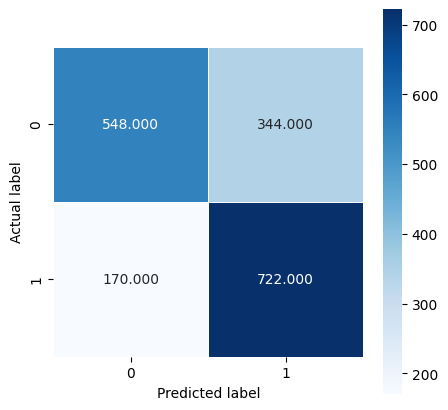

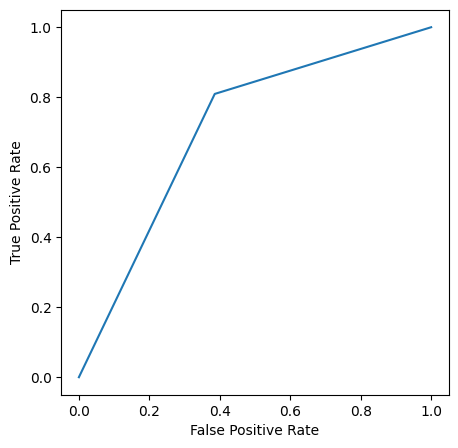

In [41]:
logistic_regression = LogisticRegression(random_state = 0, max_iter = 10000)
logistic_regression = logistic_regression.fit(X_train, y_train)
y_prediction = logistic_regression.predict(X_test)

print(classification_report(y_test, y_prediction))
print_confusion_matrix(y_test, y_prediction)
print_roc_curve(y_test, y_prediction)

# Naive Bayes

              precision    recall  f1-score   support

           0       0.71      0.63      0.67       892
           1       0.67      0.75      0.71       892

    accuracy                           0.69      1784
   macro avg       0.69      0.69      0.69      1784
weighted avg       0.69      0.69      0.69      1784



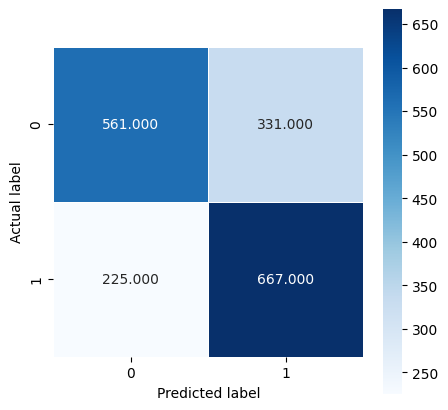

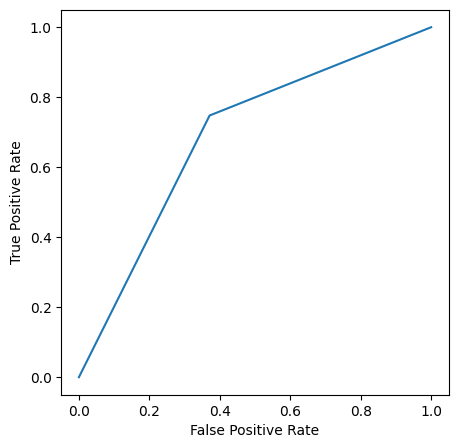

In [42]:
naive_bayes = GaussianNB()
naive_bayes = naive_bayes.fit(X_train, y_train)
y_prediction = naive_bayes.predict(X_test)

print(classification_report(y_test, y_prediction))
print_confusion_matrix(y_test, y_prediction)
print_roc_curve(y_test, y_prediction)

# Decision Tree

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       892
           1       0.64      0.64      0.64       892

    accuracy                           0.64      1784
   macro avg       0.64      0.64      0.64      1784
weighted avg       0.64      0.64      0.64      1784



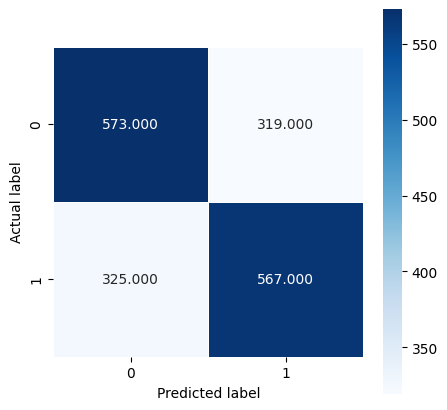

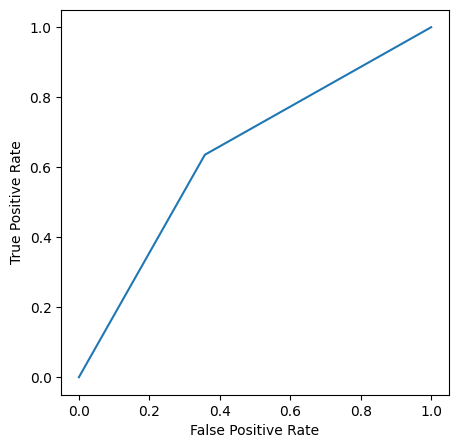

In [43]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
y_prediction = decision_tree.predict(X_test)

print(classification_report(y_test, y_prediction))
print_confusion_matrix(y_test, y_prediction)
print_roc_curve(y_test, y_prediction)

# Random Forest

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       892
           1       0.69      0.65      0.67       892

    accuracy                           0.68      1784
   macro avg       0.68      0.68      0.68      1784
weighted avg       0.68      0.68      0.68      1784



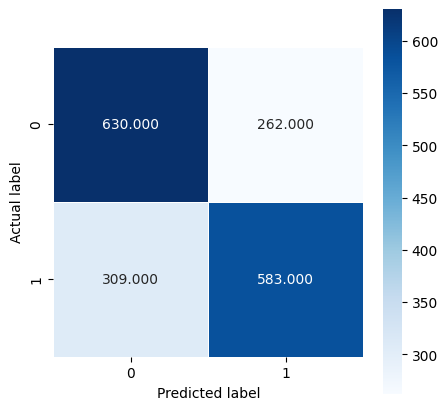

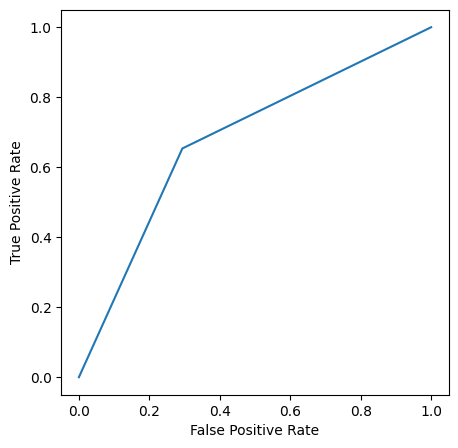

In [44]:
random_forest = RandomForestClassifier(n_estimators=10)
random_forest = random_forest.fit(X_train, y_train)
y_prediction = random_forest.predict(X_test)

print(classification_report(y_test, y_prediction))
print_confusion_matrix(y_test, y_prediction)
print_roc_curve(y_test, y_prediction)

import pickle
with open('model', 'wb') as f:
  pickle.dump(random_forest, f)

# XGBoost

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       892
           1       0.68      0.77      0.72       892

    accuracy                           0.71      1784
   macro avg       0.71      0.71      0.70      1784
weighted avg       0.71      0.71      0.70      1784



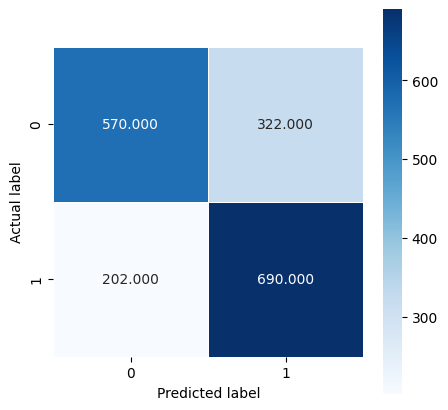

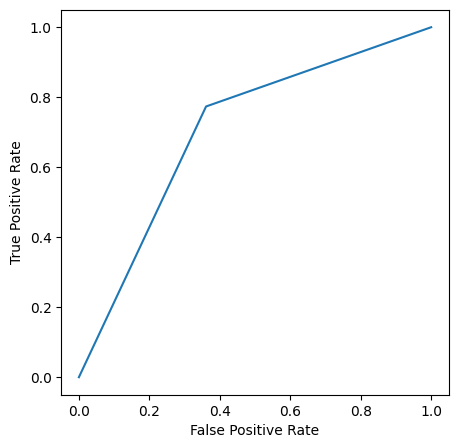

In [45]:
gradient_boost = GradientBoostingClassifier(n_estimators = 100, 
                                            learning_rate = 1.0,
                                            max_depth = 1, 
                                            random_state=0)
gradient_boost = gradient_boost.fit(X_train, y_train)
y_prediction = gradient_boost.predict(X_test)

print(classification_report(y_test, y_prediction))
print_confusion_matrix(y_test, y_prediction)
print_roc_curve(y_test, y_prediction)

# Neural Network

              precision    recall  f1-score   support

           0       0.79      0.59      0.68       892
           1       0.67      0.84      0.75       892

    accuracy                           0.72      1784
   macro avg       0.73      0.72      0.71      1784
weighted avg       0.73      0.72      0.71      1784



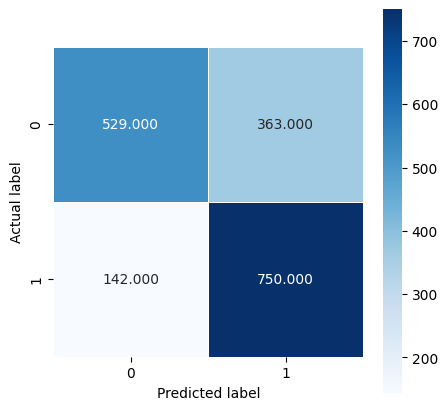

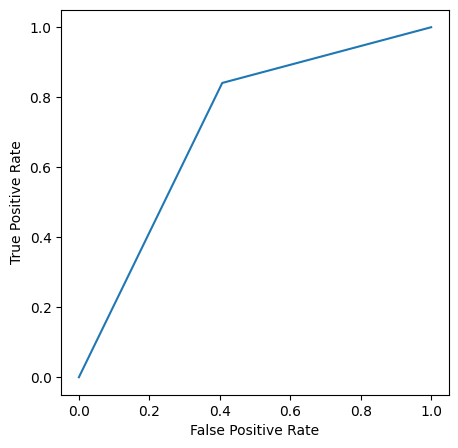

In [46]:
neural_network = MLPClassifier(hidden_layer_sizes=(100,50),max_iter=1000)
neural_network.fit(X_train,y_train)
y_prediction = neural_network.predict(X_test)

print(classification_report(y_test, y_prediction))
print_confusion_matrix(y_test, y_prediction)
print_roc_curve(y_test, y_prediction)